<a href="https://colab.research.google.com/github/pockypoem/ai-projects/blob/main/ARIMA_TLKM_JK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library dan Load Data

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 6 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

In [17]:
data = pd.read_excel("TLKM.JK.xlsx")

In [18]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-02,3980.0,3980.0,3980.0,3980.0,3310.131592,0.0
1,2017-01-03,3950.0,3990.0,3920.0,3950.0,3285.180664,71660600.0
2,2017-01-04,3880.0,3980.0,3880.0,3950.0,3285.180664,68494500.0
3,2017-01-05,3960.0,4030.0,3940.0,3950.0,3285.180664,74018400.0
4,2017-01-06,3970.0,4010.0,3960.0,4000.0,3326.765381,44136900.0
...,...,...,...,...,...,...,...
1417,2022-08-26,4510.0,4540.0,4480.0,4490.0,4490.000000,184317100.0
1418,2022-08-29,4370.0,4550.0,4360.0,4520.0,4520.000000,101529800.0
1419,2022-08-30,4580.0,4620.0,4480.0,4480.0,4480.000000,118884300.0
1420,2022-08-31,4420.0,4600.0,4420.0,4560.0,4560.000000,175300400.0


# Eksplorasi Data

In [19]:
type(data)

pandas.core.frame.DataFrame

In [20]:
data.isnull().sum()/len(data)

Date         0.000000
Open         0.000703
High         0.000703
Low          0.000703
Close        0.000703
Adj Close    0.000703
Volume       0.000703
dtype: float64

In [21]:
mean_Open = data['Open'].mean()
mean_High = data['High'].mean()
mean_Low = data['Low'].mean()
mean_Close = data['Close'].mean()
mean_AdjClose = data['Adj Close'].mean()
mean_Volume = data['Volume'].mean()

In [22]:
data['Open'].fillna(mean_Open, inplace=True)
data['High'].fillna(mean_High, inplace=True)
data['Low'].fillna(mean_Low, inplace=True)
data['Close'].fillna(mean_Close, inplace=True)
data['Adj Close'].fillna(mean_AdjClose, inplace=True)
data['Volume'].fillna(mean_Volume, inplace=True)

In [23]:
data = data.drop(['Open','Low','Close','Adj Close','Volume'],axis='columns')

In [24]:
print(data.dtypes)

Date     object
High    float64
dtype: object


In [25]:
data

,Date,High
0,2017-01-02,3980.0
1,2017-01-03,3990.0
2,2017-01-04,3980.0
3,2017-01-05,4030.0
4,2017-01-06,4010.0
...,...,...
1417,2022-08-26,4540.0
1418,2022-08-29,4550.0
1419,2022-08-30,4620.0
1420,2022-08-31,4600.0


In [26]:
#Mengubah tanggal menjadi index
con = data['Date']
data['Date']=pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
#check datatype of index
data.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13',
               ...
               '2022-08-19', '2022-08-22', '2022-08-23', '2022-08-24',
               '2022-08-25', '2022-08-26', '2022-08-29', '2022-08-30',
               '2022-08-31', '2022-09-01'],
              dtype='datetime64[ns]', name='Date', length=1422, freq=None)

In [27]:
data

,High
Date,
2017-01-02,3980.0
2017-01-03,3990.0
2017-01-04,3980.0
2017-01-05,4030.0
2017-01-06,4010.0
...,...
2022-08-26,4540.0
2022-08-29,4550.0
2022-08-30,4620.0


In [28]:
#Menginisialkan variabel High sebagai data time series
ts = data['High']
ts.head(10)

Date
2017-01-02    3980.0
2017-01-03    3990.0
2017-01-04    3980.0
2017-01-05    4030.0
2017-01-06    4010.0
2017-01-09    4030.0
2017-01-10    4030.0
2017-01-11    4000.0
2017-01-12    3970.0
2017-01-13    3970.0
Name: High, dtype: float64

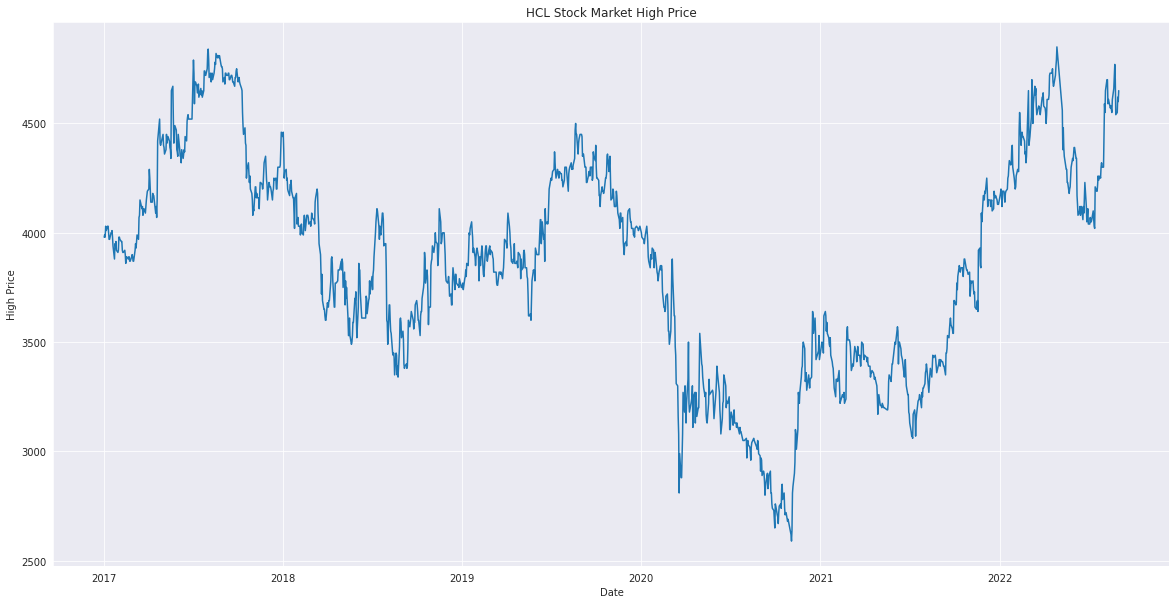

In [29]:
#Visualisasi dataset
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('HCL Stock Market High Price')
plt.plot(data['High'])

## Uji Stasioneritas Data

In [30]:
#Deklarasi fungsi untuk mengecek stasioneritas data
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Uji Hipotesis:

H0 : Data tidak stasioner

Ha : Data stasioner

Tolak H0 apabila diperoleh p-value < alpha (0,05)

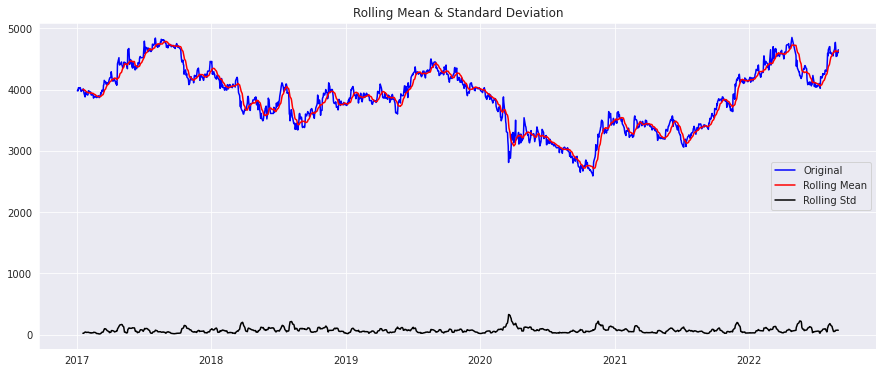

Results of Dickey-Fuller Test:
Test Statistic                   -1.789795
p-value                           0.385540
#Lags Used                        2.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


In [31]:
#Melakukan uji stasioneritas untuk dataset
test_stationarity(ts)

Diperoleh nilai p-value > 0,05, maka H0 tidak ditolak.

Jadi, data memiliki keadaan yang tidak stasioner.

Karena data belum stasioner, sehingga perlu dilakukan proses stasionerisasi data, yakni dengan proses differencing untuk memperoleh data yang stasioner.

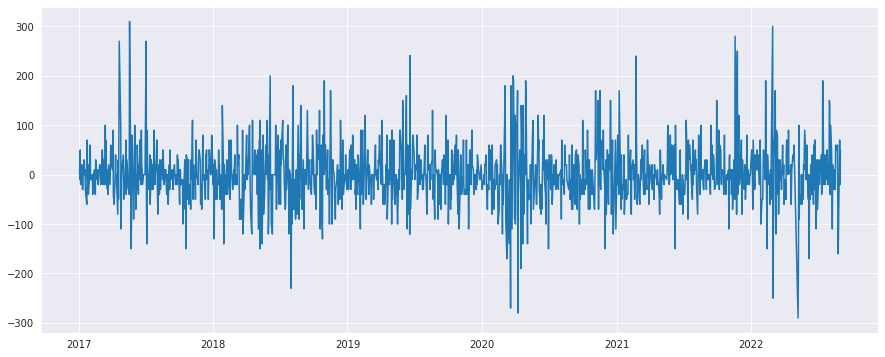

In [32]:
ts_diff_1 = ts - ts.shift()
ts_diff_1 = ts_diff_1.dropna()
plt.plot(ts_diff_1)

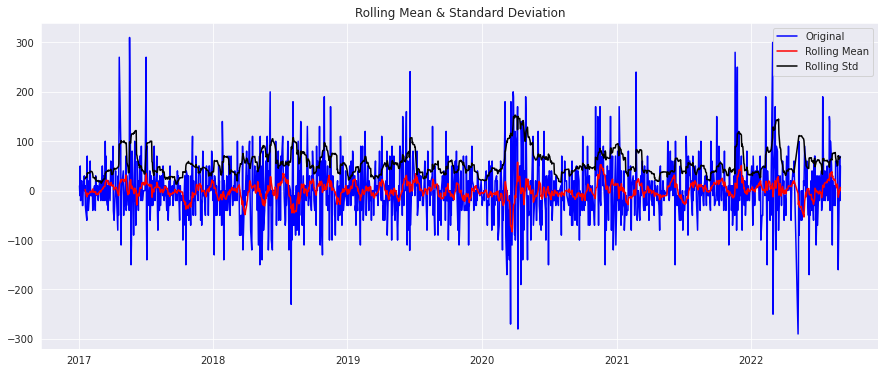

Results of Dickey-Fuller Test:
Test Statistic                  -29.780631
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1419.000000
Critical Value (1%)              -3.434967
Critical Value (5%)              -2.863579
Critical Value (10%)             -2.567856
dtype: float64


In [33]:
test_stationarity(ts_diff_1)

Setelah dilakukan proses differencing dan diuji stasioneritas data (setelah differencing), diperoleh data setelah differencing 1x telah membentuk data yang stasioner.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


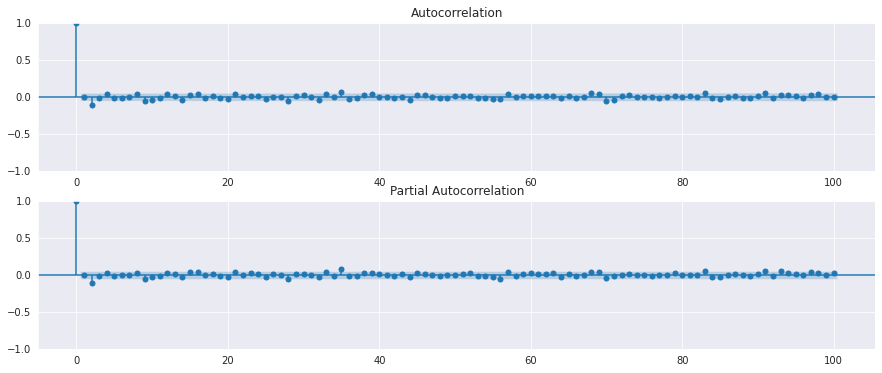

In [34]:
plt.figure()
plt.subplot(211)
plot_acf(ts_diff_1, ax=plt.gca(), lags=100)
plt.subplot(212)
plot_pacf(ts_diff_1, ax=plt.gca(), lags=100)
plt.show()

Plot ACF dan plot PACF dibentuk untuk mengetahui orde dari AR dan MA, sehingga bisa diketahui model yang sesuai untuk data.

In [35]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [36]:
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(ts.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=497.554
ARIMA(0, 0, 1) RMSE=269.986
ARIMA(0, 1, 0) RMSE=61.292
ARIMA(0, 1, 1) RMSE=61.363
ARIMA(1, 0, 0) RMSE=61.300
ARIMA(1, 0, 1) RMSE=61.374
ARIMA(1, 1, 0) RMSE=61.349
ARIMA(1, 1, 1) RMSE=61.145
Best ARIMA(1, 1, 1) RMSE=61.145


Setelah dilakukan percobaan dengan model ARIMA(p,d,q) dengan:

- orde p = 0 dan 1
- orde d = 0 dan 1
- orde q = 0 dan 1

Diperoleh model yang menghasilkan RMSE terkecil adalah model ARIMA (1,1,1).

Hal ini sesuai dengan plot ACF dan PACF yang dies down setelah lag ke-1 dan dataset telah mengalami 1x proses differencing.

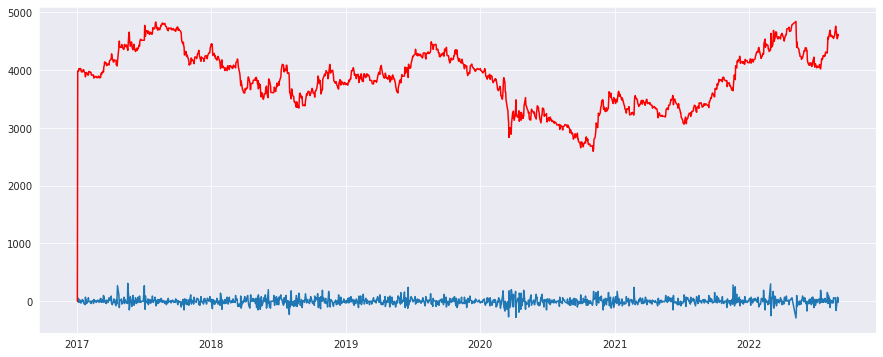

In [38]:
#Visualisasi perbandingan antara dataset setelah differencing dengan data hasil prediksi ARIMA(1,1,1)
model_ARIMA = ARIMA(ts, order=(1,1,1))
results_ARIMA = model_ARIMA.fit()
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues,copy=True)
plt.plot(ts_diff_1)             
plt.plot(predictions_ARIMA, color='red')  

In [39]:
#Informasi yang diperoleh dari pemodelan ARIMA(1,1,1) pada dataset
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1422
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7840.680
Date:                Thu, 16 Mar 2023   AIC                          15687.360
Time:                        04:09:21   BIC                          15703.138
Sample:                             0   HQIC                         15693.254
                               - 1422                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7725      0.110      7.017      0.000       0.557       0.988
ma.L1         -0.8177      0.101     -8.094      0.000      -1.016      -0.620
sigma2      3631.9833     81.621     44.498      0.000    3472.008    3791.958
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):               796.04
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.39
Prob(H) (two-sided):                  0.36   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prediksi Data

In [40]:
#Prediksi data dengan model ARIMA(1,1,1) untuk 4 hari ke depan
predict_dif = results_ARIMA.predict(start=1327,end=1330)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_ts = [ts[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data aslinya
  a = pred_ts[i] + j
  pred_ts.append(a)
predict = pd.Series(pred_ts[1:], index=predict_dif.index)
print(predict)

Date
2022-04-07     9153.746626
2022-04-08    18198.750055
2022-04-11    31851.619166
2022-04-12    50112.743016
dtype: float64


Diperoleh hasil prediksi untuk nilai harga tertinggi saham TLKM pada periode tanggal :
- 07 April 2022 = 9153.746
- 08 April 2022 = 18198.750055
- 11 April 2022 = 31851.619166
- 12 April 2022 = 50112.743016